# Tarea 2
## Random Forest - Rafael Fernández

### Librerías usadas

In [9]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import math
from graphviz import Digraph  # Correr (ubuntu) 'pip install graphviz && sudo apt install graphviz'


### Funciones de utilidad

In [10]:
def log2(number):
    if number == 0:
        return 0
    return math.log(number, 2)

def filter_data_range(data, attribute, lower, upper):
    view = data[attribute]
    bools = (lower < view) & (view <= upper)
    return data[bools]

def filter_data_equal(data, attribute, value):
    return data[data[attribute] == value]

def most_common_category(data, column):
    return data[column].mode()[0]

def are_rows_equal(data):
    return len(data.drop_duplicates()) == 1

def range_generator(range_list):
    limits = [float("-inf")] + range_list + [float("inf")]
    for index in range(len(limits) - 1):
        yield (limit[index], limit[index + 1])
        
def split_train_test(df, train_prop):
    train = df.sample(frac=train_prop, random_state=200)
    test = df.drop(train.index)
    return train, test
        
"""Recibe pandas.series de numeros reales y retorna posibles intervalos de corte"""
def gen_ranges_binary(data):
    ans = []
    percentiles = [0.3, 0.5, 0.8]
    for perc in data.quantile(percentiles):
        to_add = ((float("-inf"), perc), (perc, float("inf")))
        ans.append(to_add)
        
    return list(set(ans))


def drop_constant_cols(df):
    res = df
    for col in df.columns:
        if len(df[col].unique()) == 1:
            res = res.drop(col, axis=1)
    return res

def entropy(data, target, categories):
    records = len(data)
    value = 0
    
    if isinstance(categories[0], tuple):        
        for lower, upper in range_generator(categories):
            # print(f"Testing limit {lower} <= x < {upper}")
            prop = len(filter_data_range(data, target, lower, upper)) / records
            value += prop * log2(prop)
    else:   
        for category in categories:
            prop = len(filter_data_equal(data, target, category)) / records
            value += prop * log2(prop)
    
    return -1 * value
    
    
def info_gain(data, target, target_cats, split_var, split_cats):
    avg = 0
    if isinstance(split_cats[0], tuple):
        for lower, upper in split_cats:
            filtered = filter_data_range(data, split_var, lower, upper)
            weight = len(filtered) / len(data)
            if len(filtered) > 0:
                avg += weight * entropy(filtered, target, target_cats)
    else:
        for category in split_cats:
            filtered = filter_data_equal(data, split_var, category)
            weight = len(filtered) / len(data)
            avg += weight * entropy(filtered, target, target_cats)
            
    return entropy(data, target, target_cats) - avg

### Clases Para Representar Arcos
Son los arcos entre los nodos de cada decision tree. Guardan el valor (o rango) del atributo que le corresponde ser clasificado por esa rama.

In [11]:
class Prepicate:
    
    def __init__(self, value):
        self.value = value
    
    def evaluate(self, to_compare):
        pass
    
    def printable(self, attribue):
        pass

    
class PrepicateRange(Prepicate):

    def __init__(self, value):
        super().__init__(value)
        self.lower, self.upper = value
        
    def evaluate(self, to_compare):
        return self.lower <= to_compare < self.upper
    
    def printable(self):
        return f"{round(self.lower, 2)},\n{round(self.upper, 2)}"
        
class PrepicateEqual(Prepicate):
    
    def __init__(self, value):
        super().__init__(value)
        
    def evaluate(self, to_compare):
        return to_compare == self.value
    
    def printable(self, attribute):
        return f"{self.value}"

### Clase DecisionTree
Define un Árbol de decisión según lo visto en clases. Utiliza la funcion *info_gain* para maximizar la pérdida de entropía entre cada nodo


In [12]:
class DecisionTree:
    
    def __init__(self):
        self.question_column = None
        self.childs = [] # Guarda mas decision trees y los arcos
        self.classification = None
        self.trained_target = None
    
    """Frontend para _fit """
    def fit(self, data, target, max_depth=None, min_samples_split=None, 
            col_subset=None):
        target_cats = data[target].unique().tolist()
        
        available = data.columns.drop(target)
        self._fit(data, target, max_depth, target_cats, 0,
                  min_samples_split, col_subset, available)
    
    """Asume que todo lo numerico es continuo (no categorico)"""
    def _fit(self, data, target, max_depth, target_cats, curr_depth, 
             min_samples_split, col_subset, available_cols):
        # Loop entre los atributos y ver cual es el que produce la mayor ganancia
        # Si solo hay una columna
        self.trained_target = target
        
        if data.shape[1] == 1: # Solo una columna
            column_name = data.columns[0]
            if column_name == target:
                self.classification = most_common_category(data, target)
                return
            
            # Revisar si es que esa columna no es el target
            raise Exception("Se llego al final sin target")
        
        # Si se superó la maxima profundidad
        if ((max_depth is not None and curr_depth >= max_depth) or 
            (min_samples_split is not None and min_samples_split > len(data))):
            self.classification = most_common_category(data, target)
            return
        
        # Si todas las clases son iguales
        if are_rows_equal(data[target]):
            self.classification = data[target].iloc[0]
            return
        
        # Si todas las columnas tienen los atributos iguales excepto target
        if are_rows_equal(data.drop(target, axis=1)):
            self.classification = most_common_category(data, target)
            return
            
        max_gain = 0
        best_separator = None
        separator_categories = None
        
        
        columns = available_cols
        
        if col_subset is not None:
            size = min(col_subset, len(available_cols))
            columns = available_cols.to_series().sample(n=size)
            available_cols = available_cols.drop(columns)
        else:
            columns = data.columns.drop(target)
        
        for column in columns:
            subdata = data[column]
            
            if is_numeric_dtype(subdata):
                max_gain_range = 0
                best_range = None
                range_options = gen_ranges_binary(subdata) # Generates all posible range combinations
                for range_option in range_options:
                    # print("Probando range option", range_option)
                    
                    gain_range = info_gain(data, target, target_cats, column, range_option)
                    if gain_range > max_gain_range:
                        max_gain_range = gain_range
                        best_range = range_option # List of tuples
                        
                column_gain = max_gain_range
                column_categories = best_range
                
            else:
                column_categories = subdata.unique()
                column_gain = info_gain(data, target, target_cats, column, column_categories)
            
            if column_gain > max_gain:
                max_gain = column_gain
                best_separator = column
                separator_categories = column_categories
                
        self._generate_childs_fit(data, target, max_depth, min_samples_split, target_cats, 
                                  curr_depth + 1, best_separator, separator_categories, col_subset, available_cols)
        
    def _generate_childs_fit(self, data, target, max_depth, min_samples, target_cats, curr_depth, 
                                question_column, categories, col_subset, available):
        self.question_column = question_column
        
        range_category = isinstance(categories[0], tuple)
        
        for category in categories:
            
            if range_category:
                _range = category
                question = PrepicateRange(_range)
                lower, upper = _range
                filtered = filter_data_range(data, question_column, lower, upper)
                
            else:
                question = PrepicateEqual(category)
                filtered = filter_data_equal(data, question_column, category)
                
            # Remove question column
            filtered = filtered.drop(question_column, axis=1)
            
            new_child = DecisionTree()
            new_child._fit(filtered, target, max_depth, target_cats, curr_depth,
                           min_samples, col_subset, available)
            self.childs.append([new_child, question])
    
    
    """Receives only one entry"""
    def predict(self, data):
        if self.classification is not None:
            return self.classification
        
        for node, question in self.childs:
            if question.evaluate(data[self.question_column]):
                return node.predict(data)
            
            
    def benchmark(self, test_data):
        ans = test_data[self.trained_target]
        test_data = test_data.drop(self.trained_target, axis=1)
        
        correct = 0
        counter = 0
        for index, row in test_data.iterrows():
            result = self.predict(row)
            if result == ans.iloc[counter]:
                correct += 1
            counter += 1
        return correct / counter

### Clase RandomForest

Ejecuta el Algoritmo Random Forest visto en clases. Basado en múltiples DecisionTrees. Posee los siguientes hiperparámetros que permiten ajustar su comporamiento: 
- n_estimators: Cantidad de árboles a crear
- max_depth: Máxima profundidad de cada árbol.
- min_samples_split: Cantidad minima de tuplas para separar un nodo.
- bootstrap: Realizar un muestreo con reposiciónd del set de training en cada árbol
- col_subset: Largo del subset de atributos usados en la separación de cada nodo.

In [13]:
class RandomForest:
    
    def __init__(self):
        self.trees = []
        self.trained_target = None
    
    """Recibe un dataframe de pandas"""
    def fit(self, data, target, n_estimators=10, max_depth=None, 
            min_samples_split=None, bootstrap=True, col_subset=3):
        
        self.trees = []
        self.trained_target = target
        
        for n_tree in range(n_estimators):
            print(f"Entrenando arbol #{n_tree + 1}")
            tree_data = data
            if bootstrap:
                tree_data = data.sample(n=len(data), replace=True)
            
            new_tree = DecisionTree()
            new_tree.fit(tree_data, target, max_depth, min_samples_split, col_subset)
            self.trees.append(new_tree)
    
    
    def predict(self, data):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(data))
            
        return pd.Series(predictions).mode()[0]
    
    def benchmark(self, test_data):
        ans = test_data[self.trained_target]
        test_data = test_data.drop(self.trained_target, axis=1)
        
        correct = 0
        counter = 0
        for index, row in test_data.iterrows():
            result = self.predict(row)
            if result == ans.iloc[counter]:
                correct += 1
            counter += 1
        return correct / counter

### Funciones de visualización con Graphviz

In [14]:
def gen_image(g, tree):
    # Ya esta creado el parent
    for child, link in tree.childs:
        if child.classification is not None:
            g.node(str(hash(child)), label=child.classification)
            g.edge(str(hash(tree)), str(hash(child)), label=link.printable())
        else:
            g.node(str(hash(child)), label=child.question_column)
            g.edge(str(hash(tree)), str(hash(child)), label=link.printable())
            gen_image(g, child)

def generate_image_from_tree(tree):
    g = Digraph('arbol', filename='arbol.gv',
                 node_attr={'color': 'lightblue2', 'style': 'filled'})
    g.attr(size='20, 20')
    
    g.node(str(hash(tree)), label="Start " + tree.question_column)
    gen_image(g, tree)
    return g

* * *

## Preprocesamiento

Para obtener resultados más rápidamente, usaremos solo un porcentaje de la base de datos para obtener el set de test y entrenamiento.
Además, se eliminarán las columnas de la base de datos que tienen tienen un único valor para todas las filas (Usando la funcion de utilidad *drop_constant_cols*), lo cual no aporta para su calificación.
Finalmente separaremos la base de datos en el set de *training* y *test*


In [15]:
FILENAME = "FATS_GAIA.dat"
all_data = pd.read_csv(FILENAME)

In [30]:
PERCENTAGE = 0.1
data = all_data.sample(frac=PERCENTAGE, random_state=100)
data = drop_constant_cols(data)

In [31]:
TRAINING_PROP = 0.8
train, test = split_train_test(data, TRAINING_PROP)

## Aplicación
Se entrará un RandomForest y un DecisionTree con el mismo set de datos y luego se analizarán los resultados.

In [271]:
forest = RandomForest()
forest.fit(train, "Class", n_estimators=40, col_subset=3, max_depth=4)
print("Exactitud", forest.benchmark(test) * 100, "%")

Entrenando arbol #1
Entrenando arbol #2
Entrenando arbol #3
Entrenando arbol #4
Entrenando arbol #5
Entrenando arbol #6
Entrenando arbol #7
Entrenando arbol #8
Entrenando arbol #9
Entrenando arbol #10
Entrenando arbol #11
Entrenando arbol #12
Entrenando arbol #13
Entrenando arbol #14
Entrenando arbol #15
Entrenando arbol #16
Entrenando arbol #17
Entrenando arbol #18
Entrenando arbol #19
Entrenando arbol #20
Entrenando arbol #21
Entrenando arbol #22
Entrenando arbol #23
Entrenando arbol #24
Entrenando arbol #25
Entrenando arbol #26
Entrenando arbol #27
Entrenando arbol #28
Entrenando arbol #29
Entrenando arbol #30
Entrenando arbol #31
Entrenando arbol #32
Entrenando arbol #33
Entrenando arbol #34
Entrenando arbol #35
Entrenando arbol #36
Entrenando arbol #37
Entrenando arbol #38
Entrenando arbol #39
Entrenando arbol #40
Exactitud 87.78054862842892 %


In [33]:
tree = DecisionTree()
tree.fit(train, "Class", max_depth=6)
print("Exactitud", tree.benchmark(test) * 100, "%")

Exactitud 87.71492648891103 %


Se puede ver que en este caso, y con parámetros similares para ambos algoritmos, RandomForest tiene un mejor desempeño que DecisionTree (87.78 % vs 77.3%)

In [25]:
tree.benchmark(train)

0.8592075753800149

## Visualización
Graficaremos el DecisionTree y dos arboles de RandomForest para luego apoyarnos en ellos para el análisis.


### Gráfico de DecisionTree

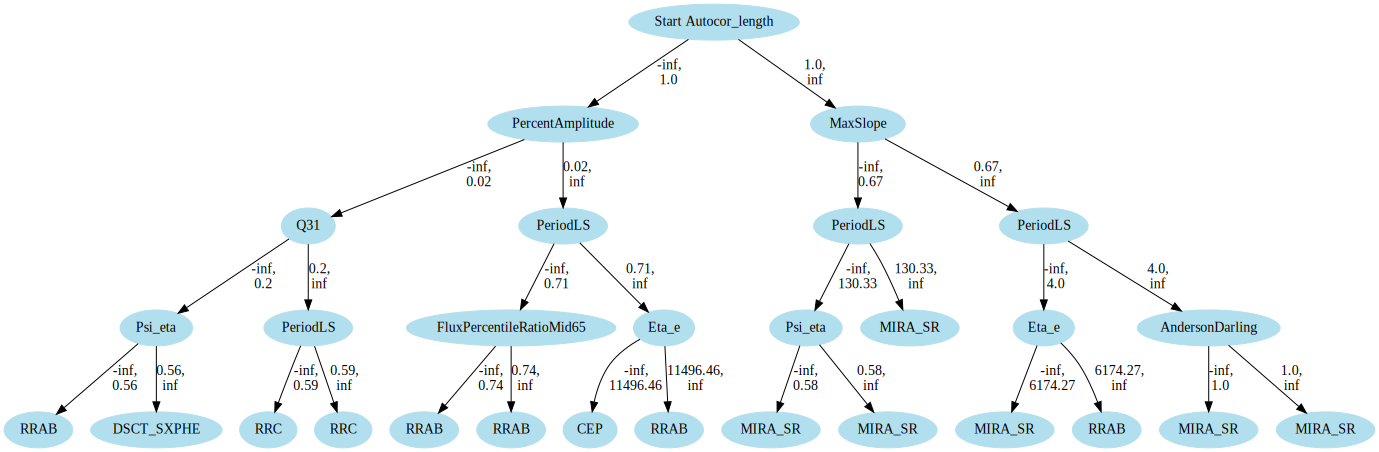

In [279]:
img = generate_image_from_tree(tree)
img

### Gráfico de Arbol #1 de RandomForest

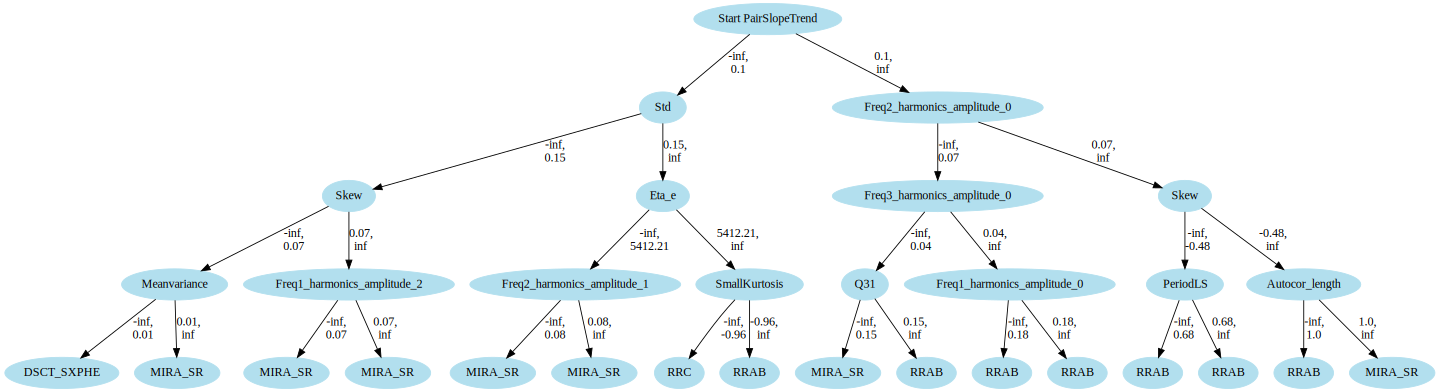

In [280]:
img2 = generate_image_from_tree(forest.trees[0])
img2

### Gráfico de Arbol #40 de RandomForest

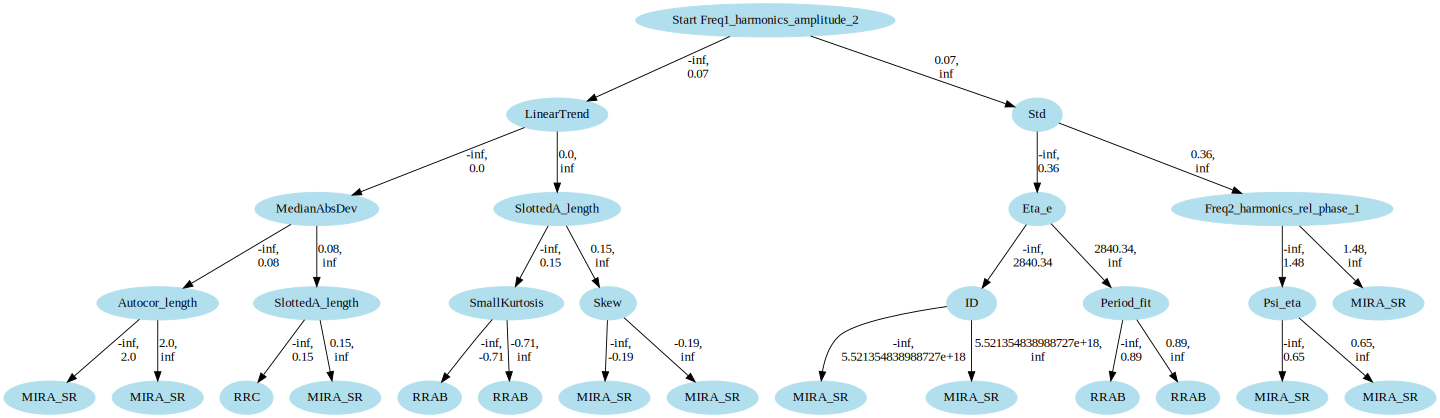

In [281]:
img3 = generate_image_from_tree(forest.trees[-1])
img3

## Explicación y Análisis
- Por los resultados vistos anteriormente, hemos visto las ventajas a la hora de predecir una variable categóríca usando el algoritmo **RandomForest** en vez de **DecisionTree**
- Es de esperar que mientras mayor sea el parámetro *n_estimators*, la exactitud de RandomForest aumente, hasta llegar a converger a una exactitud donde no cambie significativamente. Esta mejora se produce debido a que los posible errores que existen en cada uno de los DecisionTrees que componen a RandomForest se irán compensando unos a otros, dando además un modelo menos sesgado ya que se introdujeron variaciones.
- Para el caso de DecisionTree por sí solo, se espera que si se aumenta *max_depth* mucho, se produzca overfitting y el rendimiento en el set de *test* disminuya. En el caso de RandomForest esto no pasa ya que las mismas variaciones aleatorias no permitirán que el modelo se vuelva demasiado bueno para los datos, ya que las condiciones siempre cambian.
- Las variaciones en cada árbol de RandomForest producidas por *bootstrap* y el uso de columnas aleatorias cuando separamos cada nodo, se puede ver evidenciado en los gráficos, donde el arbol #1 y #40 son totalmente distintos.
- Si la profundidad de los arboles son muy bajas, tanto en DecisionTree como RandomForest, se espera que el rendimiento sea bajo, ya que se estará dejando de lado mucha información para predecir target.
